In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pdb

In [2]:
import os

In [3]:
def imshow(img):
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

In [4]:
class Config:
    genuine_directory = "sample_Signature/genuine/"
    forged_directory = "sample_Signature/forged/"
    training_batch_size = 8
    training_number_epochs = 50

In [5]:
genuine_folder_dataset = dset.ImageFolder(root=Config.genuine_directory)
forged_folder_dataset = dset.ImageFolder(root=Config.forged_directory)

In [6]:
b = random.choice(forged_folder_dataset.classes)

In [7]:
forged_folder_dataset.classes

['001',
 '003',
 '004',
 '005',
 '007',
 '011',
 '012',
 '013',
 '017',
 '023',
 '025',
 '033',
 '088']

In [8]:
'002' in forged_folder_dataset.classes

False

In [9]:
t = Image.open('sample_Signature/genuine/001/NFI-00103001.png').convert("RGB")

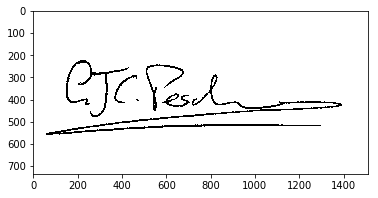

In [10]:
plt.imshow(t)

In [11]:
np.array(Image.open('sample_Signature/genuine/006/NFI-00601006.png').convert("L")).shape

(88, 191)

In [12]:
genuine_folder_dataset.imgs

[('sample_Signature/genuine/001/NFI-00101001.png', 0),
 ('sample_Signature/genuine/001/NFI-00102001.png', 0),
 ('sample_Signature/genuine/001/NFI-00103001.png', 0),
 ('sample_Signature/genuine/001/NFI-00104001.png', 0),
 ('sample_Signature/genuine/001/NFI-00105001.png', 0),
 ('sample_Signature/genuine/002/NFI-00201002.png', 1),
 ('sample_Signature/genuine/002/NFI-00202002.png', 1),
 ('sample_Signature/genuine/002/NFI-00203002.png', 1),
 ('sample_Signature/genuine/002/NFI-00204002.png', 1),
 ('sample_Signature/genuine/002/NFI-00205002.png', 1),
 ('sample_Signature/genuine/003/NFI-00301003.png', 2),
 ('sample_Signature/genuine/003/NFI-00302003.png', 2),
 ('sample_Signature/genuine/003/NFI-00303003.png', 2),
 ('sample_Signature/genuine/003/NFI-00304003.png', 2),
 ('sample_Signature/genuine/003/NFI-00305003.png', 2),
 ('sample_Signature/genuine/004/NFI-00401004.png', 3),
 ('sample_Signature/genuine/004/NFI-00402004.png', 3),
 ('sample_Signature/genuine/004/NFI-00403004.png', 3),
 ('sample_

In [13]:
t = random.choice(genuine_folder_dataset.classes)

In [14]:
a = os.listdir("{}{}".format(Config.genuine_directory, t))

In [15]:
name = "{}{}".format(Config.genuine_directory, t)

In [16]:
name

'sample_Signature/genuine/004'

In [17]:
random1 = random.choice(os.listdir("{}{}".format(Config.genuine_directory, t)))

In [18]:
t = (Image.open(f'{name}/{random1}'))

In [19]:
t = t.convert("L")

In [20]:
np.array(t).shape

(374, 636)

In [21]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, genuineImagesDataset, forgedImageDataset):
        self.genuineImages = genuineImagesDataset
        self.forgedImages = forgedImageDataset
    
    def __getitem__(self, index):
        genuine_img_random_folder = random.choice(self.genuineImages.classes)

        genuine_name = os.listdir("{}{}".format(Config.genuine_directory, genuine_img_random_folder))
        img0_genuine = random.choice(genuine_name)
        genuine_name = "{}{}/{}".format(Config.genuine_directory, genuine_img_random_folder, img0_genuine)
        genuine = random.randint(0,1)
        if genuine:
            name = os.listdir("{}{}".format(Config.genuine_directory, genuine_img_random_folder))
            img1 = random.choice(name)
            name = "{}{}/{}".format(Config.genuine_directory, genuine_img_random_folder, img1)
        else:
            if genuine_img_random_folder in self.forgedImages.classes:
                name = os.listdir("{}{}".format(Config.forged_directory, genuine_img_random_folder))
                img1 = random.choice(name)
                name = "{}{}/{}".format(Config.forged_directory, genuine_img_random_folder, img1)
            else:
                forged_img_random_folder = random.choice(self.forgedImages.classes)
                name = os.listdir("{}{}".format(Config.forged_directory, forged_img_random_folder))
                img1 = random.choice(name)
                name = "{}{}/{}".format(Config.forged_directory, forged_img_random_folder, img1)
                
    
        img0_genuine = np.array(Image.open(genuine_name).convert("RGB").resize((1000,1000)))
        img1 = np.array(Image.open(name).convert("RGB").resize((1000,1000)))
        
        return img0_genuine, img1 , torch.from_numpy(np.array([int(genuine)],dtype=np.float32))
    
    def __len__(self):
        return len(self.genuineImages.imgs)

In [22]:
siameseDataSet = SiameseNetworkDataset(genuineImagesDataset=genuine_folder_dataset, forgedImageDataset=forged_folder_dataset)

In [23]:
checking = DataLoader(siameseDataSet, batch_size=Config.training_batch_size, num_workers=8)


In [24]:
data = next(iter(checking))

In [25]:
data[2].shape

torch.Size([8, 1])

In [26]:
x1, x2, y = data

In [27]:
np.array(x1).shape

(8, 1000, 1000, 3)

In [28]:
class ConvLayer(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.conv = nn.Conv2d(inp, out, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        return F.relu(self.conv(x))

In [29]:
class siameseArchitecture(nn.Module):
    def __init__(self, layers, dense):
        super().__init__()
        self.convLayers = nn.ModuleList([ConvLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.dense = nn.ModuleList([nn.Linear(dense[i], dense[i+1]) for i in range(len(dense)-1)])
#         self.convLayers = nn.ModuleList([
#             nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
#             for i in range(len(layers) - 1)])
#         self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(dense[-1], 1)
    def forward(self, data1, data2):
        for i in self.convLayers:
            data1 = i(data1)
        for i in self.convLayers:
            data2 = i(data2)
        data1 = F.adaptive_max_pool2d(data1, 1)
        output1 = data1.view(data1.size(0), -1)
        data2 = F.adaptive_max_pool2d(data2, 1)
        output2 = data2.view(data2.size(0), -1)
        diff = (output1-output2).cuda()
        for i in self.dense:
            diff = F.relu(i(diff)).cuda()
        return torch.sigmoid(self.out(diff))

In [30]:
net = siameseArchitecture([3, 50, 100, 500], [500, 50]).cuda()

In [31]:
data[2]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]])

In [32]:
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [135]:
data

[tensor([[[[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
 
          ...,
 
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [255, 255

In [33]:
counting = []
lossf = []

In [34]:
for epochs in range(0, Config.training_number_epochs):
    for i, data in enumerate(checking):
        img0, img1, y = data
        optimizer.zero_grad()
        img0 = img0.permute(0,3,1,2)
        img0 = img0.type('torch.FloatTensor').cuda()
        img1 = img1.permute(0,3,1,2)
        img1 = img1.type('torch.FloatTensor').cuda()
        y = y.cuda()
        output = net(img0, img1)
        loss = F.binary_cross_entropy(output, y)
        loss.backward()
        optimizer.step()
#         print("hi i am loss and my loss is {}".format(loss.item()))
        if i%10==0:
#             print("output is {}".format(output))
#             print("expected is {}".format(y))
            
            print("Epoch number {}\n Current loss {}\n".format(epochs,loss.item()))
            counting.append(i)
            lossf.append(loss)


Epoch number 0
 Current loss 0.7445167303085327

Epoch number 0
 Current loss 0.5213224291801453

Epoch number 1
 Current loss 0.5566105842590332

Epoch number 1
 Current loss 0.45225247740745544

Epoch number 2
 Current loss 0.30219370126724243

Epoch number 2
 Current loss 0.3719080686569214

Epoch number 3
 Current loss 0.5977349877357483

Epoch number 3
 Current loss 0.5246403217315674

Epoch number 4
 Current loss 0.4298590421676636

Epoch number 4
 Current loss 0.2618435025215149

Epoch number 5
 Current loss 0.19852836430072784

Epoch number 5
 Current loss 0.30441993474960327

Epoch number 6
 Current loss 0.37698155641555786

Epoch number 6
 Current loss 0.4857618808746338

Epoch number 7
 Current loss 0.3082730770111084

Epoch number 7
 Current loss 0.23386630415916443

Epoch number 8
 Current loss 0.7040703892707825

Epoch number 8
 Current loss 0.35802432894706726

Epoch number 9
 Current loss 0.4382006824016571

Epoch number 9
 Current loss 0.09335263073444366

Epoch number

In [37]:
PATHGC = "sample_Signature/genuine"

In [38]:
data_dict = {}

In [39]:
def testing(data):
    img1 = torch.tensor(np.array(Image.open(data).convert("RGB").resize((1000,1000))))
    img1 = img1.permute(2,0,1).view(1,3,1000,1000)#beware hard coded
    img1 = img1.type('torch.FloatTensor').cuda()
    for i in os.listdir(PATHGC):
        image = np.random.choice(os.listdir(f"{PATHGC}/{i}"))
        genuine_name = f"{PATHGC}/{i}/{image}"
        img0 = torch.tensor(np.array(Image.open(genuine_name).convert("RGB").resize((1000,1000))))
        img0 = img0.permute(2,0,1).view(1,3,1000,1000)
        img0 = img0.type('torch.FloatTensor').cuda()
        data_dict[i] = net(img0, img1)

In [52]:
check = "sample_Signature/genuine/017/NFI-01702017.png"

In [53]:
testing(check)

In [54]:
data_dict

{'019': tensor([[0.6976]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '010': tensor([[0.3713]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '026': tensor([[0.0933]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '022': tensor([[0.1360]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '004': tensor([[0.0006]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '023': tensor([[0.9862]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '006': tensor([[0.8942]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '020': tensor([[0.6484]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '001': tensor([[4.2328e-06]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '013': tensor([[1.1441e-06]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '003': tensor([[0.0006]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '014': tensor([[0.9673]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '025': tensor([[0.0101]], device='cuda:0', grad_fn=<SigmoidBackward>),
 '024': tensor([[3.0947e-06]], device='cuda:0', grad_fn=